In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#import users_modified and user_engagement_revised
#use value_count for org_id as a feature 

In [ ]:
merged_df = users.merge(user_engagement_revised, on = 'user_id', how = 'outer')

In [ ]:
#separate date and time in creation_time as two variables
merged_df['creation_date_year'] = merged_df['creation_time'].dt.year
merged_df['creation_date_month'] = merged_df['creation_time'].dt.month
merged_df['creation_date_day_of_week'] = merged_df['creation_time'].dt.dayofweek
merged_df['creation_date_hour'] = merged_df['creation_time'].dt.hour

In [ ]:
#replace all NaNs in the has_adopted column with Falseb
merged_df['has_adopted'].fillna(False, inplace=True)

If we do an outer join, we notice that it returns a total of 12000 rows, which is equal to the number of rows in users. This means user_engagement_revise does not include users that are not already present in the users dataframe.

### 3) What Factors Predict User Adoption?

Because we believe that adopted users are more likely to be successful at using Asana in the long term than those that are not adopted, we want to know what things are likely indicators of future adoption. With this in mind, we'd like you to identify which factors predict user adoption. Applicants generally take on a modeling approach to answer this question, but you may choose whatever method you prefer.

I choose to use the Random Forest model to identify which factors predict user adoption for 3 main reasons:
1. It tells us which feature have the most impact of the model's prediction.
2. It doesn't assume a linear relationship between features and user adoption.
3. It is less prone to overfitting. 

In [ ]:
#convert categorical features to binary features
encoded_df = pd.get_dummies(merged_df, columns=['creation_source', 'email_domain', 'org_group'])


In [ ]:
merged_df['is_invited'] = merged_df['invited_by_user_id'] > 0


In [ ]:
encoded_df.columns

Index(['user_id', 'creation_time', 'name', 'email', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'login_dates', 'has_adopted', 'creation_date_year',
       'creation_date_month', 'creation_date_day_of_week',
       'creation_date_hour', 'is_invited', 'creation_source_GUEST_INVITE',
       'creation_source_ORG_INVITE', 'creation_source_PERSONAL_PROJECTS',
       'creation_source_SIGNUP', 'creation_source_SIGNUP_GOOGLE_AUTH',
       'email_domain_Other', 'email_domain_cuvox.de', 'email_domain_gmail.com',
       'email_domain_gustr.com', 'email_domain_hotmail.com',
       'email_domain_jourrapide.com', 'email_domain_yahoo.com',
       'org_group_0-20th Percentile', 'org_group_20-40th Percentile',
       'org_group_40-60th Percentile', 'org_group_60-80th Percentile',
       'org_group_80-100th Percentile'],
      dtype='object')

In [ ]:

xvars = ['creation_date_year', 'creation_date_month', 'creation_date_day_of_week', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip',	
         'org_id', 'creation_date_hour', 'is_invited',
 'creation_source_GUEST_INVITE',
 'creation_source_ORG_INVITE',
 'creation_source_PERSONAL_PROJECTS',
 'creation_source_SIGNUP',
 'creation_source_SIGNUP_GOOGLE_AUTH',
 'email_domain_Other',
 'email_domain_cuvox.de',
 'email_domain_gmail.com',
 'email_domain_gustr.com',
 'email_domain_hotmail.com',
 'email_domain_jourrapide.com',
 'email_domain_yahoo.com', 
 'org_group_0-20th Percentile', 'org_group_20-40th Percentile',
       'org_group_40-60th Percentile', 'org_group_60-80th Percentile',
       'org_group_80-100th Percentile' ]
yvar = 'has_adopted'

In [ ]:
#check if there are any NA values in each column
for variable in xvars:
    if merged_df[variable].isna().any():
        print(variable, ":", merged_df[variable].isna().sum())
    else:
        print(variable, "does not have NaN values")


creation_date_year does not have NaN values
creation_date_month does not have NaN values
creation_date_day_of_week does not have NaN values
opted_in_to_mailing_list does not have NaN values
enabled_for_marketing_drip does not have NaN values
org_id does not have NaN values
creation_date_hour does not have NaN values
is_invited does not have NaN values


KeyError: 'creation_source_GUEST_INVITE'

We will keep the NaNs in the login_date

In [ ]:
from sklearn.model_selection import train_test_split

df_to_fit = encoded_df[xvars+[yvar]].dropna()

X_train, X_test, y_train, y_test = train_test_split(
    df_to_fit[xvars], df_to_fit[yvar], test_size = 0.25, random_state = 1)

print(len(X_train), len(y_train) )
print(len(X_test), len(y_test) )

9000 9000
3000 3000


#### I am going to use RandomizedSearchCV to apply K-fold Cross Validation to come up with the final validation metrics with the model.

For random forests, the parameters I tune are the 
- number of trees, 
- max # of features, 
- depth, 
- min # of samples in a leaf, and 
- min # of samples to split a node. 

If your model is overfitting, reducing the tree depth, min # of samples in a leaf, and min # of samples to split a node should have a regularizing effect.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 21, 32, 43, 54, 65, 76, 87, 98, 110, None],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 155, 261, 366, 472, 577, 683, 788, 894, 1000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=1, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=87, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=366; total time=   3.4s
[CV] END bootstrap=True, max_depth=87, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=366; total time=   3.4s
[CV] END bootstrap=False, max_depth=76, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=472; total time=   5.6s
[CV] END bootstrap=False, max_depth=76, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=472; total time=   5.6s
[CV] END bootstrap=False, max_depth=76, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=472; total time=   5.7s
[CV] END bootstrap=True, max_depth=87, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=366; total time=   3.4s
[CV] END bootstrap=True, max_depth=21, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=894

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 21, 32, 43, 54, 65,
                                                      76, 87, 98, 110, None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 155, 261, 366, 472,
                                                         577, 683, 788, 894,
                                                         1000]},
                   random_state=1, verbose=2)

In [ ]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 43,
 'bootstrap': True}

In [ ]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions ^ test_labels)

    mape = 100 * np.mean(predictions.astype(int) ^ test_labels.astype(int))
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.5f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.5f}%.'.format(accuracy))
    
    return accuracy

base_model = RandomForestClassifier(n_estimators = 10, random_state = 1)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_train, y_train)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_train, y_train)

print('Improvement of {:0.5f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 0.02289 degrees.
Accuracy = 97.71111%.
Model Performance
Average Error: 0.11011 degrees.
Accuracy = 88.98889%.
Improvement of -8.92654%.


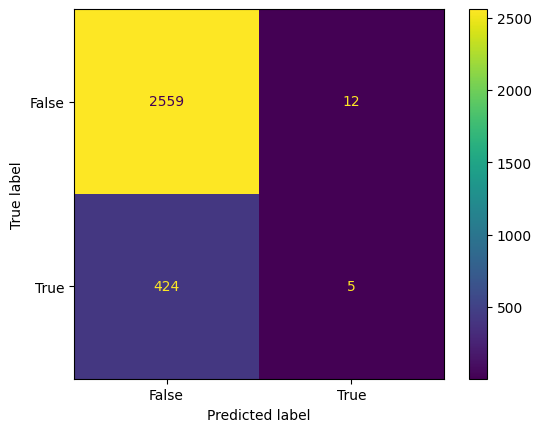

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

In [ ]:
print('Accuracy score: {:.4f}'.format(accuracy_score(y_test, y_pred)))


Accuracy score: 0.8547


Text(0, 0.5, 'Mean decrease in impurity')

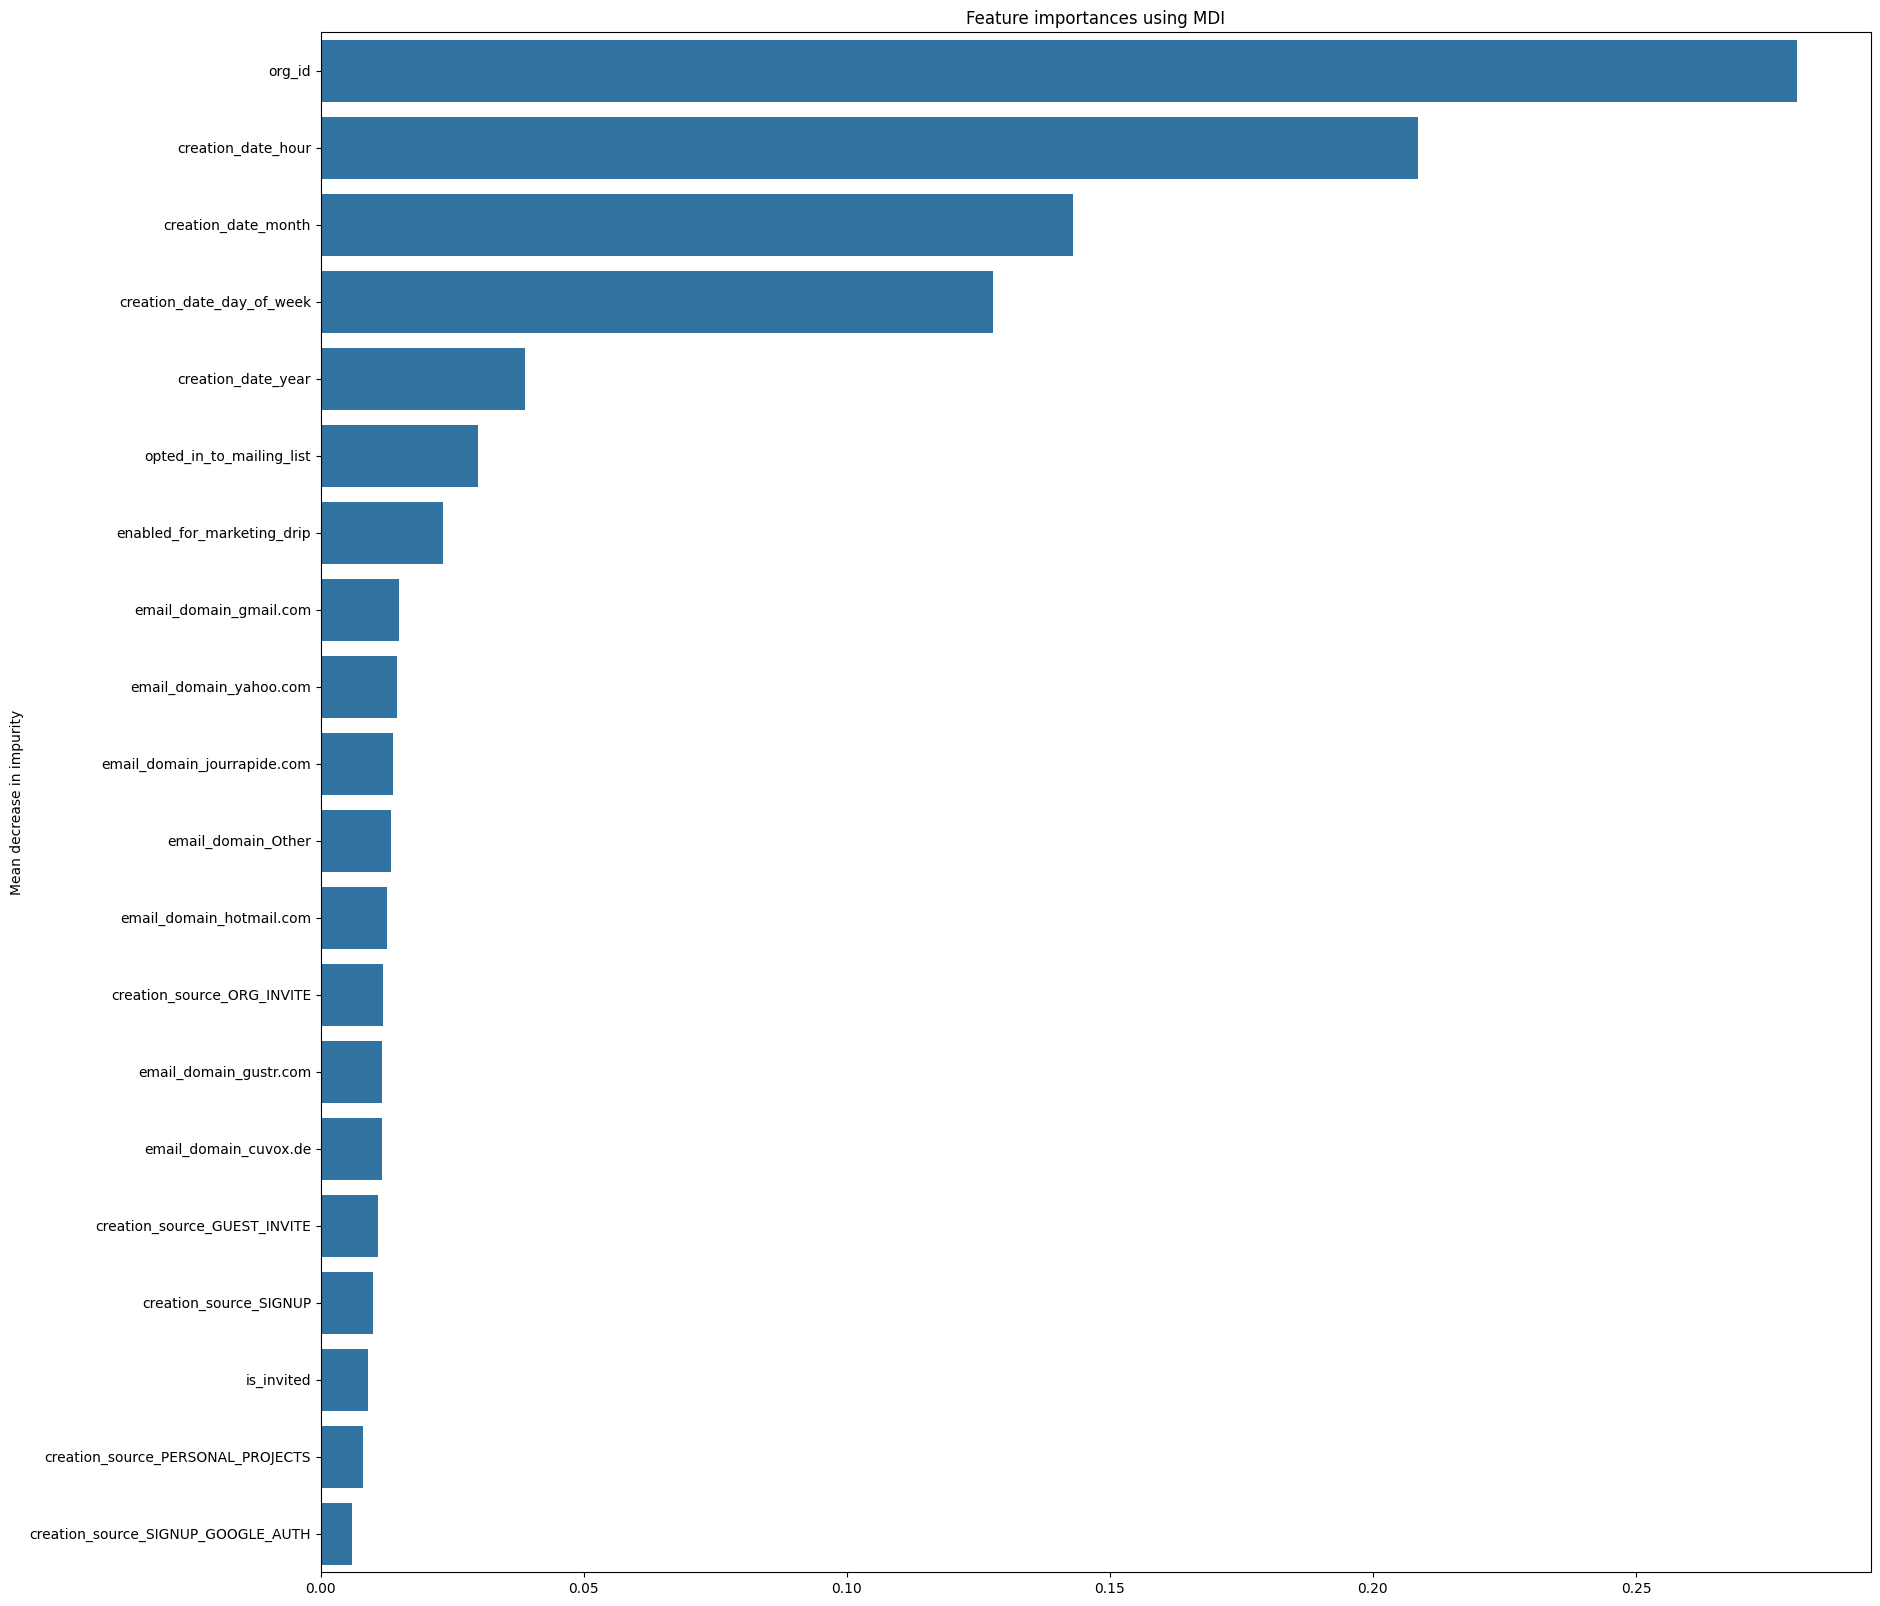

In [ ]:
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=X_train.columns)
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)
forest_importances.sort_values(inplace=True, ascending=False)

fig, ax = plt.subplots(figsize = (20,20))
sns.barplot(x=forest_importances.values, y=forest_importances.index, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

##### 3a) Writeup associated with what factors predict user adoption?